# CAICT 風機結冰預測 - Data Sampling

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

<a id='home'></a>
## 1. Outline
[events summary](#events summary)  
[Events of original data](#Events of original data)  
[Events of resample data](#Events of resample data)    
[Events of original data with prediction result](#Events of original data with prediction result)  
[end](#end)

### Parameters 

In [1]:
plotchart=False #控制要不要畫每個event的圖

### **Load Data and Modules**

**Load Python modules:**

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from operator import xor
#from imblearn.under_sampling import TomekLinks
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import SMOTE

import sklearn as sk
from sklearn.metrics import precision_score

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"


In [141]:
def timerangeCheck(t, start, end):
    return (t>=start) & (t<=end)
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}

def event_info(data, event_id, pred=False):
    print('event:',event_id)
    evtdata = data[data['event']==event_id]
    evtdata_nor=evtdata[evtdata['label']==0]
    evtdata_abnor=evtdata[evtdata['label']==1]
    evtdata_unknown=evtdata[evtdata['label']==2]
    nor_min = ((evtdata_nor['time'].iloc[-1] - evtdata_nor['time'].iloc[0]).total_seconds())/60
    abnor_min = ((evtdata_abnor['time'].iloc[-1] - evtdata_abnor['time'].iloc[0]).total_seconds())/60
    unknown_min = 0 if evtdata_unknown.empty else ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60    
    event_msg = pd.DataFrame({'type':['normal','unknown','abnormal']})
    event_msg['minute']=[nor_min,unknown_min,abnor_min]
    event_msg['hour']=[nor_min/60,unknown_min/60,abnor_min/60]
    print(event_msg)
#    dummy = plt.figure(figsize=[17,2])
#    dummy=plt.plot(evtdata['timestamp'],evtdata['wind_speed'], color='blue')
#    dummy=plt.show()
    
#    dummy = plt.figure(figsize=[17,2])
#    dummy=plt.plot(evtdata['timestamp'],evtdata['power'], color='gray')
#    dummy=plt.show()
    
#    dummy = plt.figure(figsize=[17,2])
#    dummy=plt.plot(evtdata['timestamp'],evtdata['environment_tmp'], color='red')
#    dummy=plt.show()
    
#    dummy = plt.figure(figsize=[17,2])
#    dummy=plt.plot(evtdata['timestamp'],evtdata['power']-evtdata['wind_speed'], color='blue')
#    dummy=plt.show()
    
    dummy = plt.figure(figsize=[17,2])
    dummy=plt.plot(evtdata_nor['timestamp'],evtdata_nor['label'],label='normal', color='green',marker='o')
    dummy=plt.plot(evtdata_abnor['timestamp'],evtdata_abnor['label'],label='abnormal', color='red',marker='o')
    dummy=plt.plot(evtdata_unknown['timestamp'],evtdata_unknown['label'],label='unknown', color='gray',marker='o')
    dummy=plt.legend()
    dummy =plt.ylim(-1,3)
    dummy = plt.title('True Label')
    dummy=plt.show()
    
#    dummy = plt.figure(figsize=[17,2])
#    c='blue'
#    for group in set(evtdata['group']):
#        gdata = evtdata[evtdata['group']==group]
#        dummy=plt.plot(gdata['timestamp'],gdata['label'],label='g'+str(group), color=c,marker='o')
#        c = 'green' if c=='blue' else 'blue'
#    dummy=plt.show()

    if pred:
        evtdata_prednor=evtdata[evtdata['pred']==0]
        evtdata_predabnor=evtdata[evtdata['pred']==1]
        evtdata_predunknown=evtdata[evtdata['pred']==2]
        dummy = plt.figure(figsize=[17,2])
        dummy=plt.plot(evtdata_prednor['timestamp'],evtdata_prednor['pred'],label='normal', color='green',marker='o')
        dummy=plt.plot(evtdata_predabnor['timestamp'],evtdata_predabnor['pred'],label='abnormal', color='red',marker='o')
        dummy=plt.plot(evtdata_predunknown['timestamp'],evtdata_predunknown['pred'],label='unknown', color='gray',marker='o')
        dummy=plt.legend()
        dummy =plt.ylim(-1,3)
        dummy = plt.title('Prediction Label')
        dummy=plt.show()
        
    dummy = plt.figure(figsize=[17,2])
    dummy=plt.plot(evtdata['timestamp'],evtdata['label'],label='event'+str(event_id), color='blue', marker='o')
    dummy=plt.legend()
    dummy =plt.ylim(-1,3)
    dummy = plt.title('True Label')
    dummy=plt.show()
    
    if pred:
        dummy = plt.figure(figsize=[17,2])
        dummy=plt.plot(evtdata['timestamp'],evtdata['pred'],label='event'+str(event_id), color='blue', marker='o')
        dummy=plt.legend()
        dummy =plt.ylim(-1,3)
        dummy = plt.title('Prediction Label')
        dummy=plt.show()
        dummy = plt.figure(figsize=[17,2])
        dummy=plt.plot(evtdata['timestamp'],evtdata['predprop'],label='event'+str(event_id), color='blue', marker='o')
        dummy=plt.legend()
        dummy =plt.ylim(0,2)
        dummy = plt.title('Predtion Probability')
        dummy=plt.show()
 
        
    
    return event_msg

def assign_eventid(data):
    label_col = data['label']
    label_col = label_col.values
    event_end=False
    event_id = 0;
    label_previous=0
    event_id_col = []
    for label in label_col: 
        if (label==0) & (label_previous==1):
            event_end=True
        label_previous = label;
        if event_end:
            event_end=False
            event_id=event_id+1
        event_id_col.append(event_id)    
    data['event']=event_id_col
    return data

def events_summary(data):
    events_info = pd.DataFrame(columns=('eventid', 'nor_min','unknown_min', 'abnor_min', 'nor_cnt', 'unknown_cnt', 'abnor_cnt','nor_idx_start','nor_idx_end','unknown_idx_start','abnor_idx_start', 'abnor_idx_end','no_unknown'))
    for eventid in set(data['event']):
        data_event = data[data['event']==eventid]
        evtdata_nor=data_event[data_event['label']==0]
        evtdata_abnor=data_event[data_event['label']==1]
        evtdata_unknown=data_event[data_event['label']==2]

        nor_min = ((evtdata_nor['time'].iloc[-1] - evtdata_nor['time'].iloc[0]).total_seconds())/60
        abnor_min =  0 if evtdata_abnor.empty else ((evtdata_abnor['time'].iloc[-1] - evtdata_abnor['time'].iloc[0]).total_seconds())/60
        #unknown_min = ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60
        unknown_min = 0 if evtdata_unknown.empty else ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60    
        event_cnt = data_event['event'].count()
        nor_cnt = evtdata_nor['event'].count()
        abnor_cnt = 0 if evtdata_abnor.empty else evtdata_abnor['event'].count()
        #unknown_cnt= evtdata_unknown['event'].count()
        unknown_cnt = 0 if evtdata_unknown.empty else evtdata_unknown['event'].count()

        nor_idx_start= evtdata_nor.index[0]
        nor_idx_end= evtdata_nor.index[-1]
        
        abnor_idx_start= -1 if evtdata_abnor.empty else evtdata_abnor.index[0]
        abnor_idx_end= -1 if evtdata_abnor.empty else evtdata_abnor.index[-1]
        unknown_idx_start= abnor_idx_start if evtdata_unknown.empty else evtdata_unknown.index[0]

        no_known= 'Y' if evtdata_unknown.empty else 'N'
        events_info.loc[eventid] = [eventid, nor_min, unknown_min, abnor_min, nor_cnt, unknown_cnt, abnor_cnt,nor_idx_start,nor_idx_end, unknown_idx_start, abnor_idx_start, abnor_idx_end,no_known]
    return events_info

#根據事件的數據量, 從事件前後正常的區間取同樣多的數據
def resample_policy_p1(events_info):
    resample_info = pd.DataFrame(columns=('eventid', 'abnor_cnt','event_start', 'event_end'))
    for idx, row in events_info.iterrows():
        event_id = row['eventid']
        abnor_cnt = row['abnor_cnt']
        event_start = row['nor_idx_end'] - abnor_cnt
        event_end = row['abnor_idx_end'] + abnor_cnt
        if abnor_cnt==0:
            resample_info.loc[event_id] = [event_id, 0, 0, 0]
        else:
            resample_info.loc[event_id] = [event_id, abnor_cnt, event_start, event_end]
    return resample_info

#從不良事件的中間往前取pass:fail 2:1的數據
def resample_policy_p2(events_info):
    resample_info = pd.DataFrame(columns=('eventid', 'abnor_cnt','event_start', 'event_end'))
    for idx, row in events_info.iterrows():
        event_id = row['eventid']
        abnor_cnt = row['abnor_cnt']
        if abnor_cnt==0:
            resample_info.loc[event_id] = [event_id, 0, 0, 0]
            continue
        event_start = row['nor_idx_end']-abnor_cnt
        event_end = row['abnor_idx_start']+int(abnor_cnt/2)
        resample_info.loc[event_id] = [event_id, abnor_cnt, event_start, event_end]
    return resample_info

**Load input data.** 

In [142]:
#%run -i 'load_data.py'
data_15 = pd.read_csv('data/goodformat_15.csv')
data_21 = pd.read_csv('data/goodformat_21.csv')
data_test = pd.read_csv('data/ice1/test/08/08_data.csv')

data_15 = data_15.fillna(2)
data_21 = data_21.fillna(2)


** change time format from string to datetime**

In [143]:
data_15['time']=pd.to_datetime(data_15['time'])
data_21['time']=pd.to_datetime(data_21['time'])
data_test['time']=pd.to_datetime(data_test['time'])

data_15['timestamp'] = data_15['time'].apply(lambda x: x.timestamp())
data_21['timestamp'] = data_21['time'].apply(lambda x: x.timestamp())
data_test['timestamp'] = data_test['time'].apply(lambda x: x.timestamp())

** assign event id**

In [144]:
data_15 = assign_eventid(data_15)
data_21 = assign_eventid(data_21)

<a id='events summary'></a>
## Events summary  
[home](#home)

In [145]:
events_summary_15 = events_summary(data_15)
events_summary_21 = events_summary(data_21)
events_summary_15
events_summary_21

,eventid,nor_min,unknown_min,abnor_min,nor_cnt,unknown_cnt,abnor_cnt,nor_idx_start,nor_idx_end,unknown_idx_start,abnor_idx_start,abnor_idx_end,no_unknown
0,0,4206.0,1237.0,52.0,5727,860,443,0,5840,4756,6587,7029,N
1,1,5258.0,119.0,112.0,43020,372,265,7030,50049,50050,50422,50686,N
2,2,413.0,118.0,113.0,3383,1000,951,50687,54069,54070,55070,56020,N
3,3,8579.0,637.0,737.0,39486,1114,2101,56021,95506,95507,95621,98721,N
4,4,4978.0,16.0,13.0,35032,139,106,98722,133753,133754,133893,133998,N
5,5,2140.0,27.0,41.0,14016,230,352,133999,148014,148015,148245,148596,N
6,6,297.0,1478.0,3294.0,2120,2349,3188,148597,150716,150717,151717,156253,N
7,7,3799.0,118.0,113.0,29550,1000,951,156254,185803,185804,186804,187754,N
8,8,154.0,162.0,800.0,1321,1031,1254,187755,189075,189076,190107,191360,N
9,9,399.0,0.0,17.0,3212,0,148,191361,194572,194573,194573,194720,Y


,eventid,nor_min,unknown_min,abnor_min,nor_cnt,unknown_cnt,abnor_cnt,nor_idx_start,nor_idx_end,unknown_idx_start,abnor_idx_start,abnor_idx_end,no_unknown
0,0,4449.0,32.0,78.0,12020,270,659,0,12019,12020,12290,12948,N
1,1,5177.0,118.0,113.0,40083,1000,747,12949,53031,53032,54032,54778,N
2,2,427.0,119.0,112.0,2437,1000,951,54779,57215,57216,58216,59166,N
3,3,3595.0,111.0,112.0,20717,575,951,59167,79883,79884,80459,81409,N
4,4,3325.0,0.0,26.0,9716,0,217,81410,91125,91126,91126,91342,Y
5,5,9027.0,118.0,113.0,48850,1000,434,91343,140192,140193,141193,141626,N
6,6,75.0,94.0,49.0,637,791,414,141627,142263,142264,143055,143468,N
7,7,83.0,118.0,113.0,477,1000,951,143469,143945,143946,144946,145896,N
8,8,56.0,411.0,405.0,472,1222,1407,145897,146368,146369,147369,148997,N
9,9,2406.0,118.0,113.0,17021,1000,951,148998,166018,166019,167019,167969,N


<a id='Events of original data'></a>
** Events of original data**  
[home](#home)

event: 0
       type  minute       hour
0    normal  4206.0  70.100000
1   unknown  1237.0  20.616667
2  abnormal    52.0   0.866667


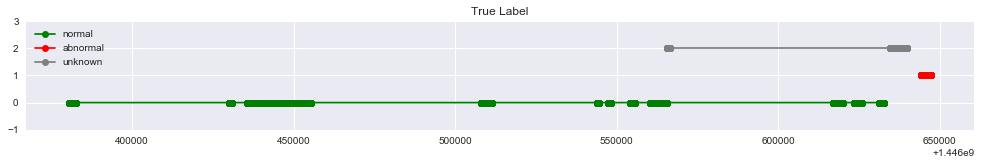

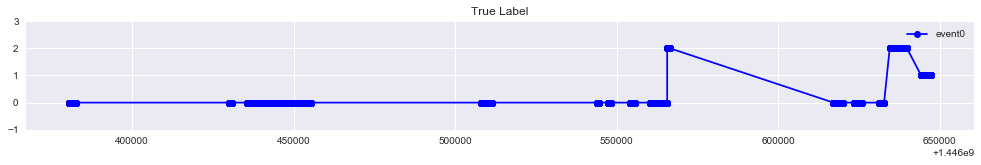

event: 1
       type  minute       hour
0    normal  5258.0  87.633333
1   unknown   119.0   1.983333
2  abnormal   112.0   1.866667


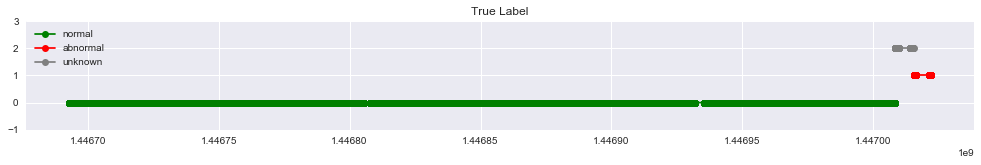

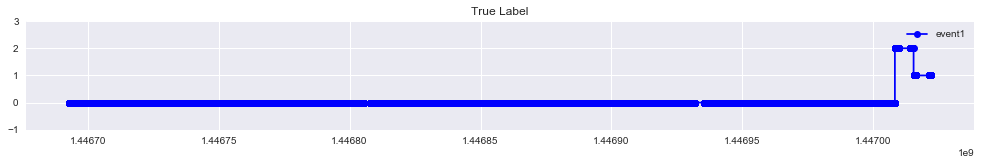

event: 2
       type  minute      hour
0    normal   413.0  6.883333
1   unknown   118.0  1.966667
2  abnormal   113.0  1.883333


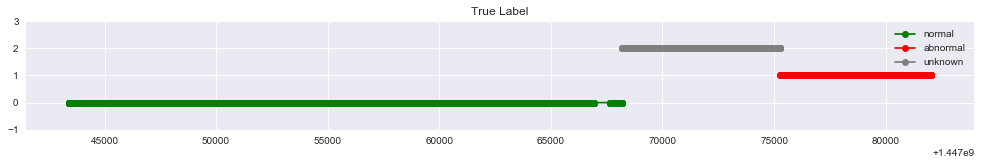

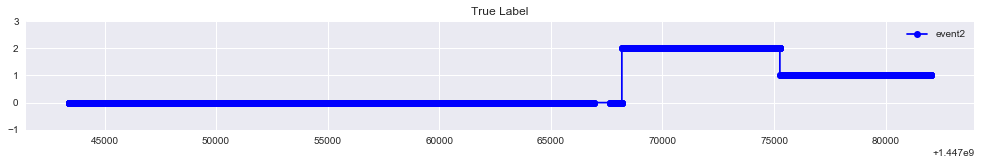

event: 3
       type  minute        hour
0    normal  8579.0  142.983333
1   unknown   637.0   10.616667
2  abnormal   737.0   12.283333


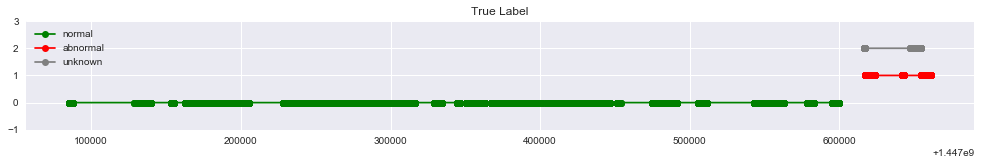

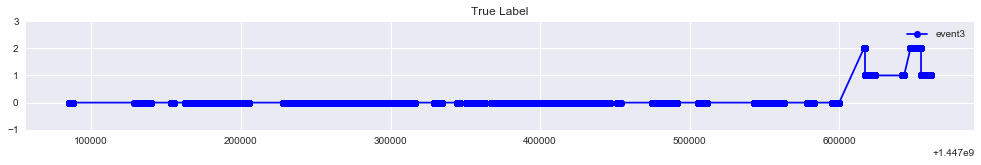

event: 4
       type  minute       hour
0    normal  4978.0  82.966667
1   unknown    16.0   0.266667
2  abnormal    13.0   0.216667


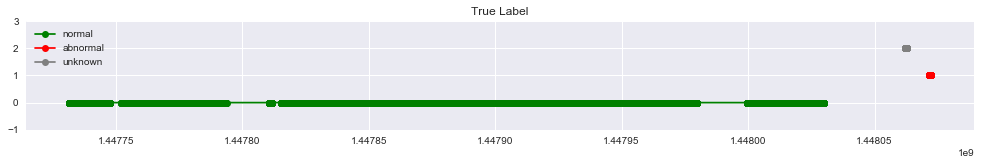

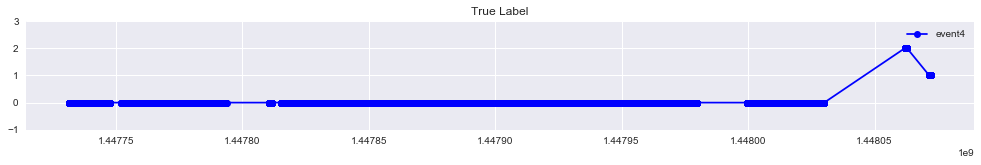

event: 5
       type  minute       hour
0    normal  2140.0  35.666667
1   unknown    27.0   0.450000
2  abnormal    41.0   0.683333


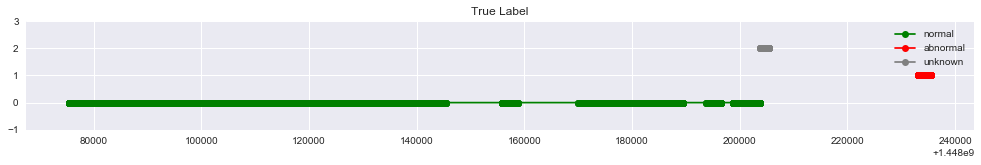

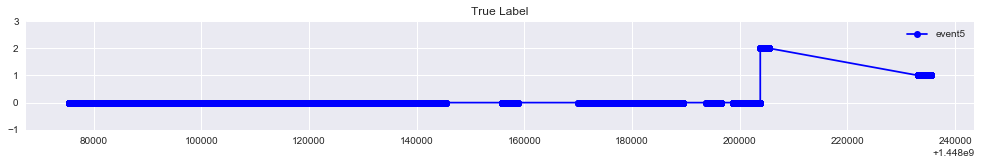

event: 6
       type  minute       hour
0    normal   297.0   4.950000
1   unknown  1478.0  24.633333
2  abnormal  3294.0  54.900000


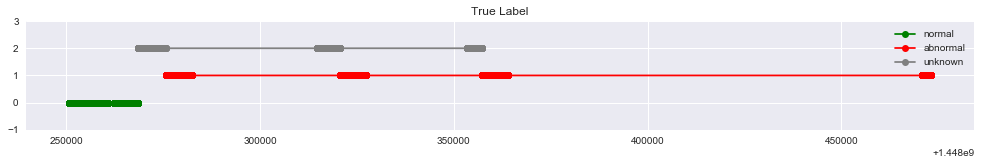

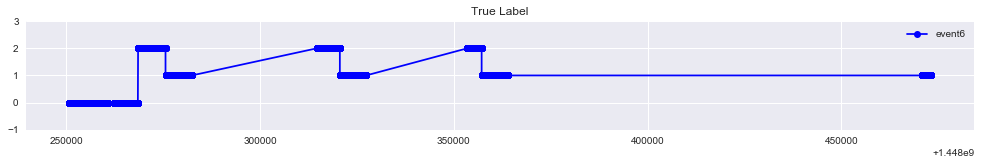

event: 7
       type  minute       hour
0    normal  3799.0  63.316667
1   unknown   118.0   1.966667
2  abnormal   113.0   1.883333


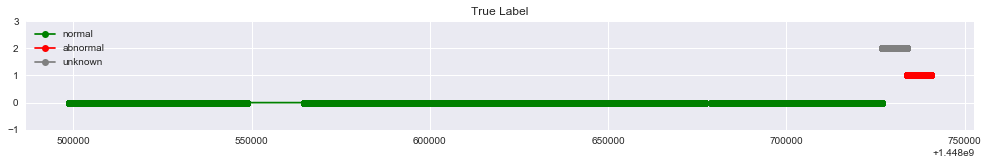

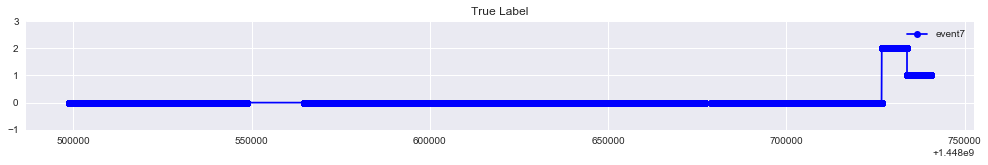

event: 8
       type  minute       hour
0    normal   154.0   2.566667
1   unknown   162.0   2.700000
2  abnormal   800.0  13.333333


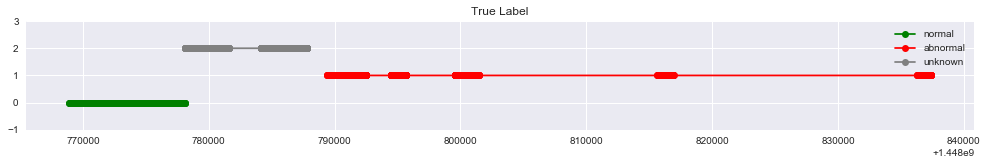

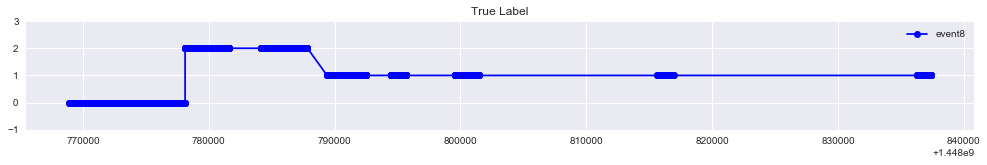

event: 9
       type  minute      hour
0    normal   399.0  6.650000
1   unknown     0.0  0.000000
2  abnormal    17.0  0.283333


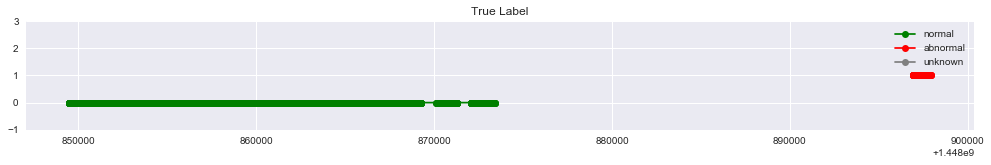

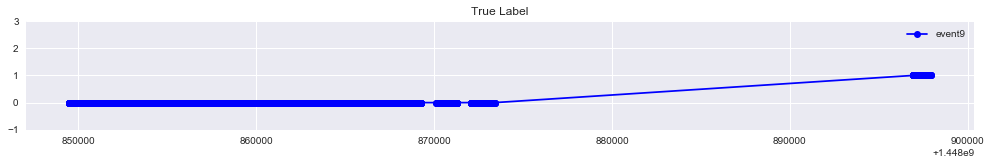

event: 10
       type  minute       hour
0    normal  2984.0  49.733333
1   unknown   116.0   1.933333
2  abnormal   111.0   1.850000


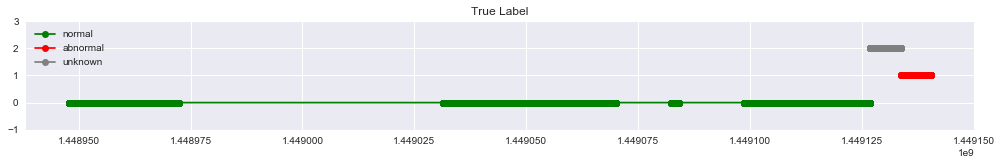

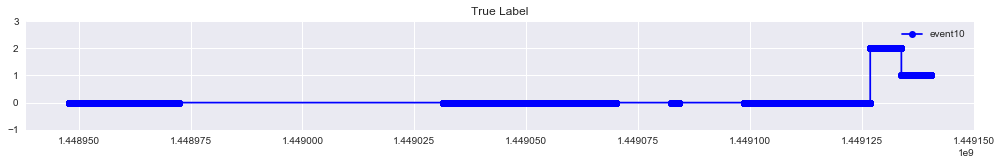

event: 11
       type  minute       hour
0    normal  1281.0  21.350000
1   unknown   105.0   1.750000
2  abnormal   193.0   3.216667


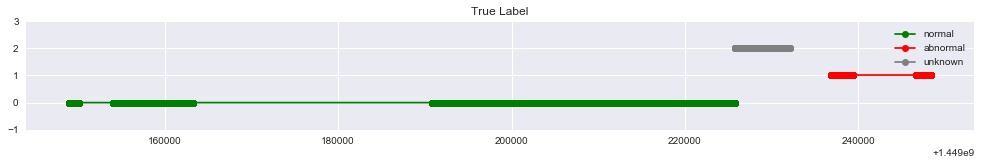

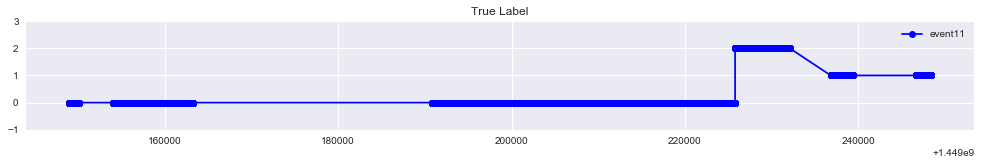

event: 12
       type  minute      hour
0    normal    79.0  1.316667
1   unknown   116.0  1.933333
2  abnormal   111.0  1.850000


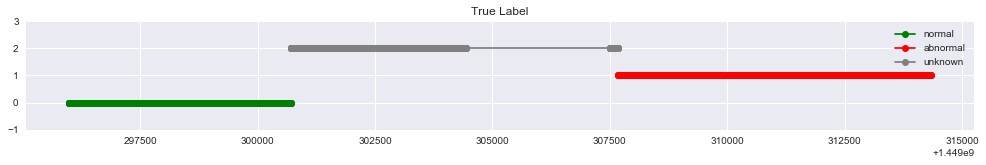

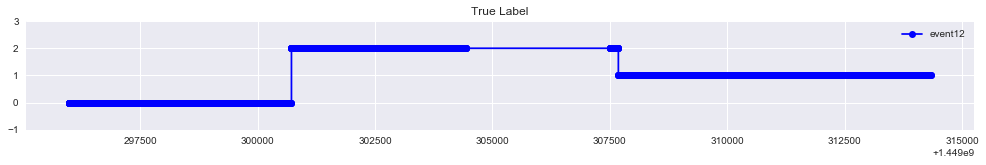

event: 13
       type  minute       hour
0    normal  1526.0  25.433333
1   unknown  1703.0  28.383333
2  abnormal  1717.0  28.616667


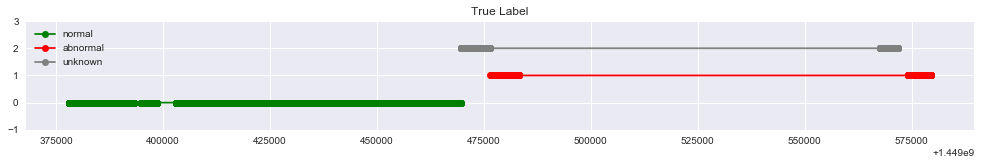

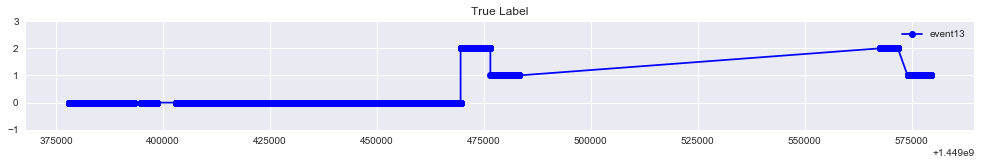

event: 14
       type  minute      hour
0    normal   345.0  5.750000
1   unknown   116.0  1.933333
2  abnormal   110.0  1.833333


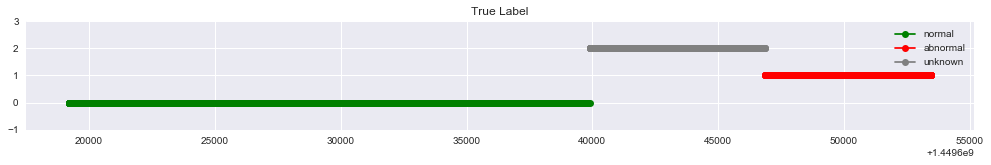

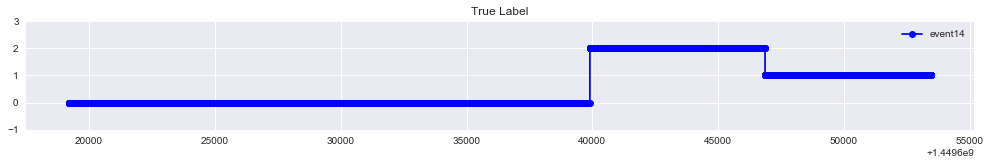

event: 15
       type  minute       hour
0    normal  2358.0  39.300000
1   unknown   116.0   1.933333
2  abnormal   111.0   1.850000


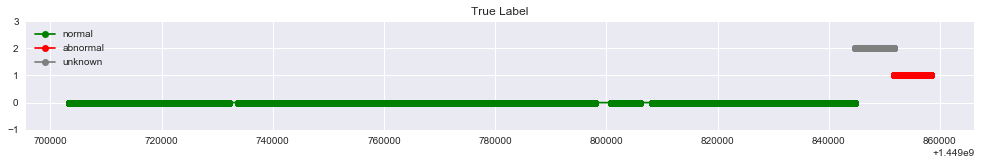

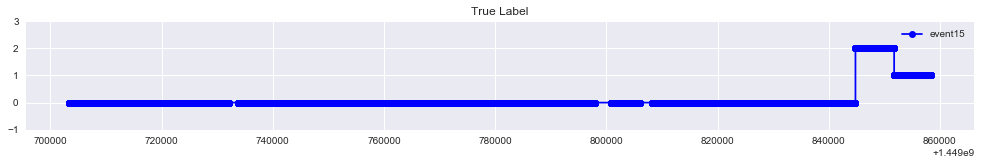

event: 16
       type  minute      hour
0    normal    65.0  1.083333
1   unknown   116.0  1.933333
2  abnormal   211.0  3.516667


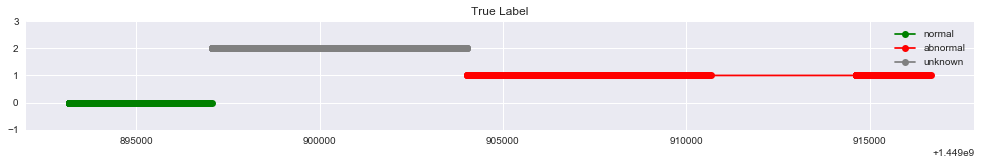

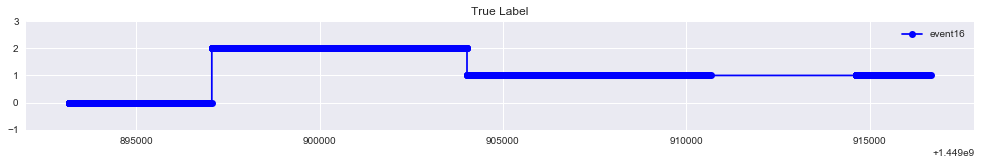

event: 17
       type  minute  hour
0    normal    15.0  0.25
1   unknown    69.0  1.15
2  abnormal   105.0  1.75


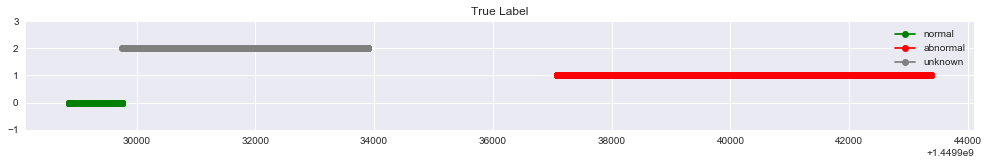

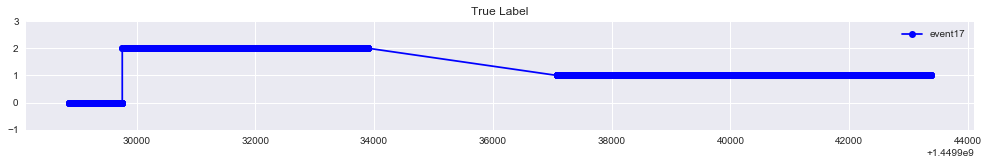

event: 18
       type  minute      hour
0    normal   562.0  9.366667
1   unknown     0.0  0.000000
2  abnormal   250.0  4.166667


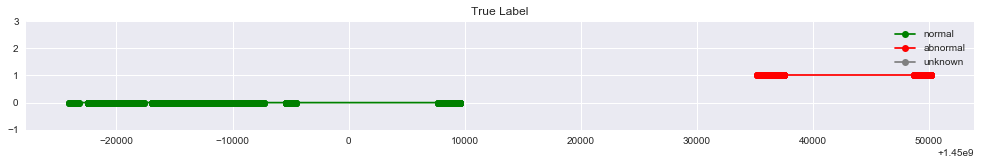

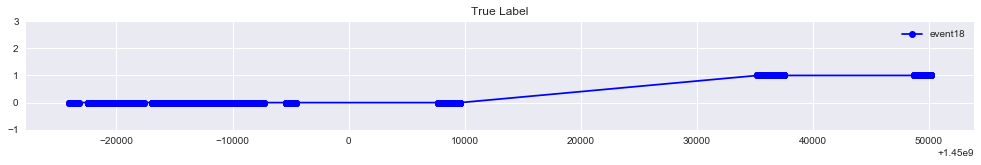

event: 19
       type  minute       hour
0    normal  1878.0  31.300000
1   unknown   116.0   1.933333
2  abnormal   111.0   1.850000


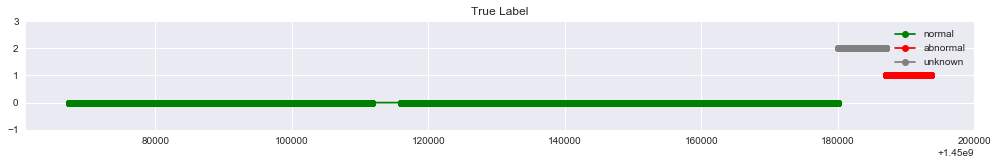

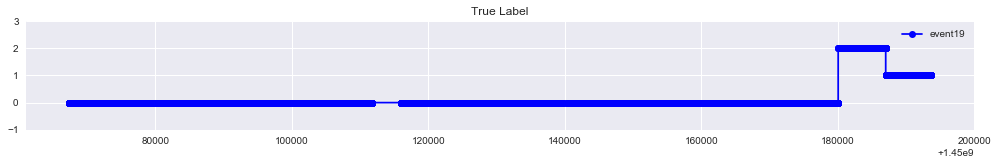

event: 20
       type  minute       hour
0    normal  2698.0  44.966667
1   unknown   116.0   1.933333
2  abnormal    68.0   1.133333


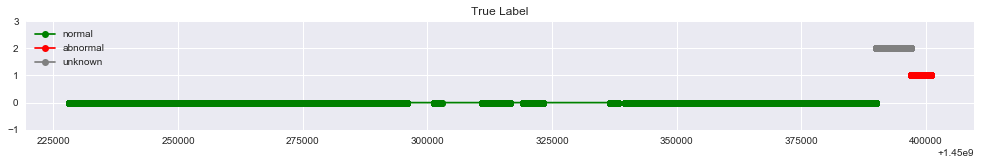

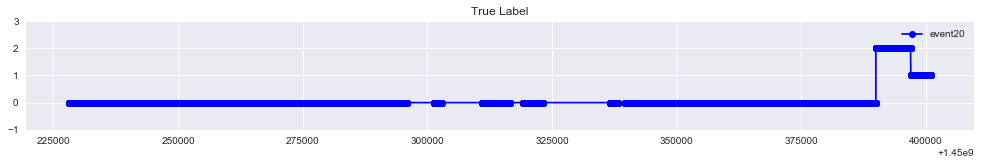

event: 21
       type  minute       hour
0    normal  1747.0  29.116667
1   unknown     0.0   0.000000
2  abnormal   117.0   1.950000


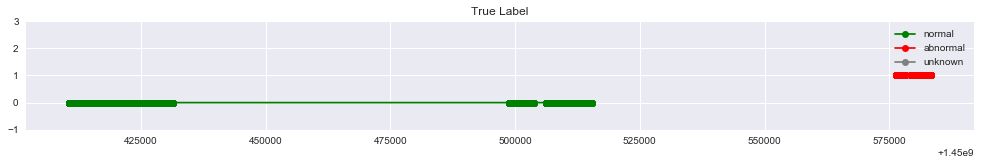

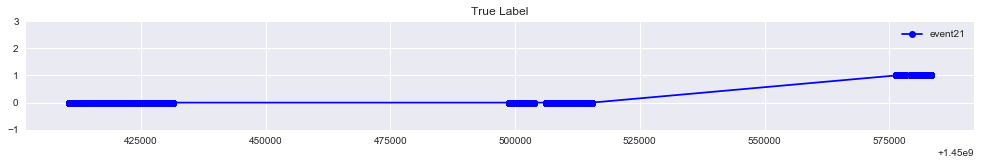

event: 22
       type  minute       hour
0    normal  2458.0  40.966667
1   unknown    95.0   1.583333
2  abnormal   110.0   1.833333


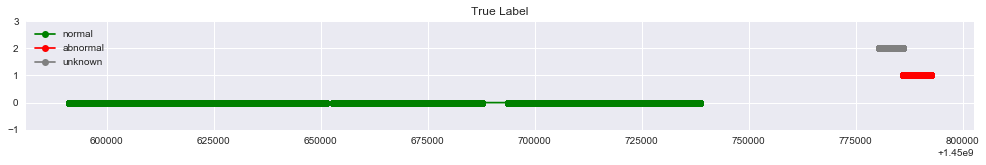

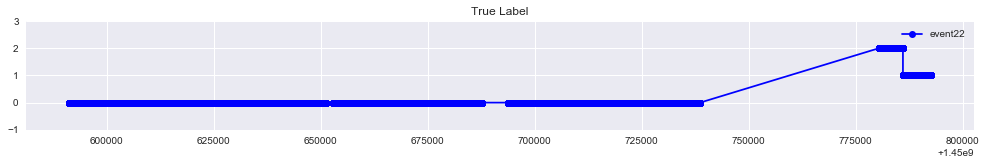

event: 23
       type  minute       hour
0    normal  5555.0  92.583333
1   unknown    18.0   0.300000
2  abnormal   110.0   1.833333


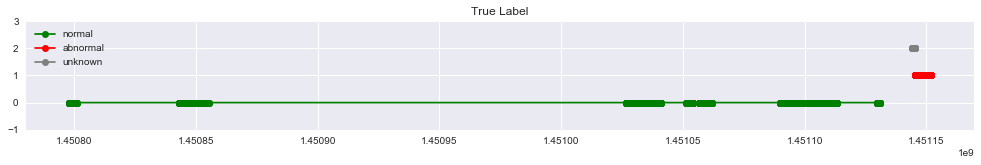

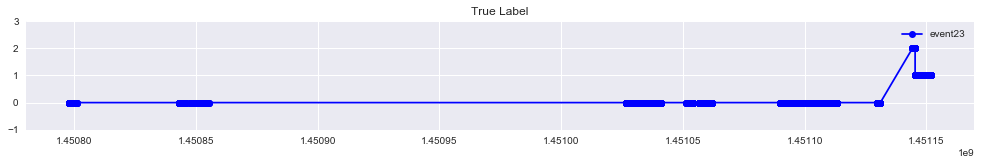

event: 24
       type  minute        hour
0    normal  7555.0  125.916667
1   unknown   116.0    1.933333
2  abnormal   111.0    1.850000


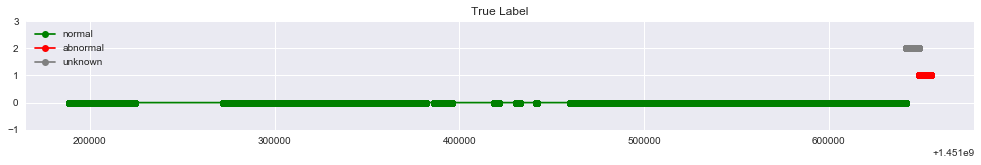

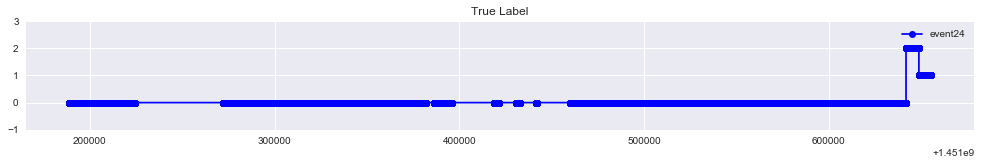

In [146]:
if(plotchart):
    for eventid in set(data_15['event']):
        dummy = event_info(data_15,eventid)

** define balanced data set **

In [147]:
resample_info_p1_15 = resample_policy_p1( events_summary_15)
resample_info_p2_15 = resample_policy_p2( events_summary_15)
resample_info_p1_21 = resample_policy_p1( events_summary_21)
resample_info_p2_21 = resample_policy_p2( events_summary_21)

In [148]:
resample_info_p2_15

,eventid,abnor_cnt,event_start,event_end
0,0,443,5397,6808
1,1,265,49784,50554
2,2,951,53118,55545
3,3,2101,93405,96671
4,4,106,133647,133946
5,5,352,147662,148421
6,6,3188,147528,153311
7,7,951,184852,187279
8,8,1254,187821,190734
9,9,148,194424,194647


** resample **

In [149]:
data = data_15
resample_data_p1_15 = pd.DataFrame()
for idx, row in resample_info_p1_15.iterrows():
    event_id = row['eventid']
    abnor_cnt = row['abnor_cnt']
    event_start = row['event_start']
    event_end = row['event_end']
    resample_data_i = data[event_start:event_end].copy()
    resample_data_i['event']=event_id
    resample_data_p1_15 =resample_data_p1_15.append(resample_data_i)

data = data_15
resample_data_p2_15 = pd.DataFrame()
for idx, row in resample_info_p2_15.iterrows():
    event_id = row['eventid']
    abnor_cnt = row['abnor_cnt']
    event_start = row['event_start']
    event_end = row['event_end']
    resample_data_i = data[event_start:event_end].copy()
    resample_data_i['event']=event_id
    resample_data_p2_15 =resample_data_p2_15.append(resample_data_i)
    

In [150]:
data = data_21
resample_data_p1_21 = pd.DataFrame()
for idx, row in resample_info_p1_21.iterrows():
    event_id = row['eventid']
    abnor_cnt = row['abnor_cnt']
    event_start = row['event_start']
    event_end = row['event_end']
    resample_data_i = data[event_start:event_end].copy()
    resample_data_i['event']=event_id
    resample_data_p1_21 =resample_data_p1_21.append(resample_data_i)

data = data_21
resample_data_p2_21 = pd.DataFrame()
for idx, row in resample_info_p2_21.iterrows():
    event_id = row['eventid']
    abnor_cnt = row['abnor_cnt']
    event_start = row['event_start']
    event_end = row['event_end']
    resample_data_i = data[event_start:event_end].copy()
    resample_data_i['event']=event_id
    resample_data_p2_21 =resample_data_p2_21.append(resample_data_i)
    

In [153]:
resample_data_p1_15.to_csv('data/resample_data_p1_15.csv',index=False)
resample_data_p2_15.to_csv('data/resample_data_p2_15.csv',index=False)
resample_data_p1_21.to_csv('data/resample_data_p1_21.csv',index=False)
resample_data_p2_21.to_csv('data/resample_data_p2_21.csv',index=False)

<a id='Events of resample data'></a>
** Events of resample data**  
[home](#home)

In [139]:
plotchart=True
if(plotchart):
    for eventid in set(resample_data_p2_15['event']):
        dummy = event_info(resample_data_p2_15,eventid)

event: 0


IndexError: single positional indexer is out-of-bounds

<a id='Events of original data with prediction result'></a>
### restore the predict result from another jupyter norebook 
[home](#home)

### 完整的 風機 21 with prediction result

In [14]:
data_target = data_21.copy()

In [15]:
%store -r
data_target['pred']=list(pred_t_sm.values)
data_target['predprop']=list(pred_failprop.values)

In [20]:
if(plotchart):
    for eventid in set(data_target['event']):
        dummy = event_info(data_target,eventid, pred=True)

<a id='end'></a>
[Home](#home)